In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from keras import regularizers, optimizers
from keras.optimizers import Adam, RMSprop
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras.models import load_model

# File Extracting
So our file is going to be in binary and we are going to need to get it out
You can thinks of this process of encoding and decoding, but allows us to store a large number of images, and the vectors, in a much smaller file

In [2]:
# this is a dictionairy used to define the structure
# of our binary file
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'title': tf.io.FixedLenFeature([], tf.string),
    'price': tf.io.FixedLenFeature([], tf.float32),
    'unbalanced_vector': tf.io.VarLenFeature(tf.int64),
    'balanced_vector': tf.io.VarLenFeature(tf.int64),
    'unbalanced_model_vector': tf.io.VarLenFeature(tf.int64),
    'unbalanced_brand_vector': tf.io.VarLenFeature(tf.int64),
}

In [3]:
# this is a function used to extract the binary information
def parse_example(example_proto):
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.decode_jpeg(parsed_example['image'])
    title = tf.strings.lower(parsed_example['title'])
    price = parsed_example['price']
    unbalanced_vector = tf.sparse.to_dense(parsed_example['unbalanced_vector'])
    balanced_vector = tf.sparse.to_dense(parsed_example['balanced_vector'])
    unbalanced_model_vector = tf.sparse.to_dense(parsed_example['unbalanced_model_vector'])
    unbalanced_brand_vector = tf.sparse.to_dense(parsed_example['unbalanced_brand_vector'])
    return image, title, price, unbalanced_vector, balanced_vector, unbalanced_model_vector, unbalanced_brand_vector

In [4]:
dataset = tf.data.TFRecordDataset('Downloaded_Images_Binary_Brands_Models.tfrecords')
dataset = dataset.map(parse_example)


2023-11-25 15:57:17.782303: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-25 15:57:17.782331: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-25 15:57:17.782338: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-25 15:57:17.782368: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-25 15:57:17.782382: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Here some code to show we extracted everything correctly!

Unbalanced Vector: [0 1 0 0 0 0 0 0 0 0]
Balanced Vector: [0 1 0 0 0 0 0 0 0 0]
Model Vector: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
Brand Vector: [1 0 0 0 0 0]
tf.Tensor(107.0, shape=(), dtype=float32)


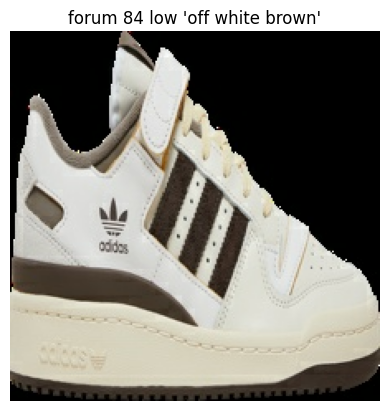

In [5]:
for image, title, price, unbalanced_vector, balanced_vector,unbalanced_model_vector,unbalanced_brand_vector in dataset.take(1):
    print("Unbalanced Vector:", unbalanced_vector.numpy())
    print("Balanced Vector:", balanced_vector.numpy())
    print("Model Vector:", unbalanced_model_vector.numpy())
    print("Brand Vector:", unbalanced_brand_vector.numpy())
    print(price)
    plt.imshow(image.numpy())
    plt.title(title.numpy().decode('utf-8'))
    plt.axis('off')  
    plt.show()

# Splitting up training and Testing Data
    * We are going to shuffle the data incase
    the website organizes the data in set, non-random
    way. 

## Base Dataset
    * No techniques except shuffling and shape!

In [6]:
# Size of Data
buffer_size = sum([1 for _ in dataset])  
# Shuffle the data
shuffled_dataset = dataset.shuffle(buffer_size, reshuffle_each_iteration=False)
# 80/20 Split, Taking will take the first 80% and skip will take the last
train_size = int(0.8 * buffer_size)
train_dataset = shuffled_dataset.take(train_size)
val_dataset = shuffled_dataset.skip(train_size)

## Printing it out again to make sure everything looks right!

Unbalanced Vector: [1 0 0 0 0 0 0 0 0 0]
Balanced Vector: [1 0 0 0 0 0 0 0 0 0]
Model Vector: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
Brand Vector: [1 0 0 0 0 0]
tf.Tensor(57.0, shape=(), dtype=float32)


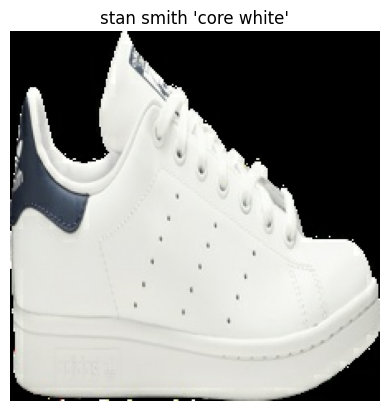

Unbalanced Vector: [0 0 1 0 0 0 0 0 0 0]
Balanced Vector: [0 0 0 0 0 0 1 0 0 0]
Model Vector: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
Brand Vector: [0 0 0 1 0 0]
tf.Tensor(294.0, shape=(), dtype=float32)


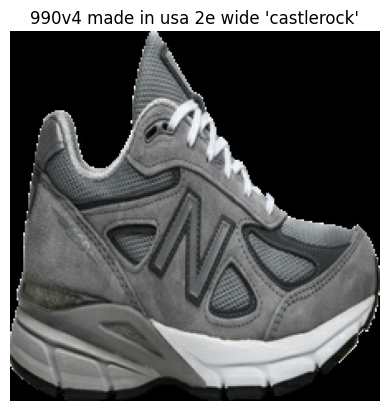

Unbalanced Vector: [0 1 0 0 0 0 0 0 0 0]
Balanced Vector: [0 1 0 0 0 0 0 0 0 0]
Model Vector: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Brand Vector: [0 0 0 0 1 0]
tf.Tensor(107.0, shape=(), dtype=float32)


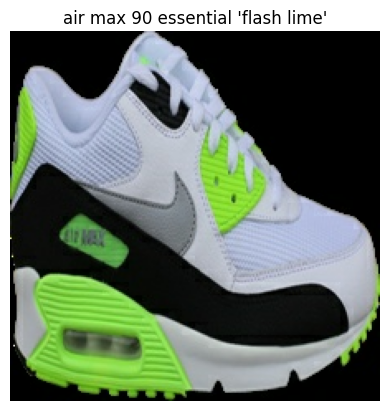

In [7]:
for image, title, price, unbalanced_vector, balanced_vector, unbalanced_model_vector,unbalanced_brand_vector in val_dataset.take(3):
    print("Unbalanced Vector:", unbalanced_vector.numpy())
    print("Balanced Vector:", balanced_vector.numpy())
    print("Model Vector:", unbalanced_model_vector.numpy())
    print("Brand Vector:", unbalanced_brand_vector.numpy())
    print(price)
    plt.imshow(image.numpy())
    plt.title(title.numpy().decode('utf-8'))
    plt.axis('off')  
    plt.show()

## Data Technique 1 - Normalization!
* This can be done simply by dividing by 255 (Pixel score)
* This will improve and is going to be necessary for vgg16

In [8]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_vector

unbalanced_vector_train_dataset = train_dataset.map(preprocess).batch(16)
unbalanced_vector_val_dataset = val_dataset.map(preprocess).batch(16)

In [9]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, balanced_vector

balanced_vector_train_dataset = train_dataset.map(preprocess).batch(16)
balanced_vector_val_dataset = val_dataset.map(preprocess).batch(16)

In [10]:
# This is a function to divide the image / 255, preprocess is 
# a function apart of keras and has certain rules, and it allows us to declare are predictor/response
# we are going to be using these keras functions a lot
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_brand_vector

brand_vector_train_dataset = train_dataset.map(preprocess).batch(16)
brand_vector_val_dataset = val_dataset.map(preprocess).batch(16)

In [11]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_model_vector

model_vector_train_dataset = train_dataset.map(preprocess).batch(16)
model_vector_val_dataset = val_dataset.map(preprocess).batch(16)

## Data Technique 2 - Data Augmentaton!
* This is a technique used to introduce variations to our training data and can have enourmouse
benefits

DID NOT HELP WITH THIS MODEL, KEEPING TO SHOW WHAT IT DOES

In [12]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector,unbalanced_brand_vector, augment = True):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    if augment:
        image = tf.image.random_flip_left_right(image)  
        image = tf.image.random_flip_up_down(image) 
        # image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
       
        # image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        
    return image, unbalanced_brand_vector

aug_train_dataset = train_dataset.map(preprocess).batch(16)
aug_val_dataset = val_dataset.map(preprocess).batch(16)



## Data Technique 3 - Class Weights!
* This is a technique used to balance data by providing a weight based on class size
* DID NOT HELP KEEPING TO SHOW WHAT IT DOES


In [13]:
# counts for our vector
class_counts = {
    'A':258,
    'B':489,
    'C':88,
    'D':115,
    'E':1390,
    'F':46,
}
# code to get the weights for each class
total_samples = sum(class_counts.values())
num_classes = len(class_counts)
class_weights = {class_label: (total_samples / (num_classes * count)) for class_label, count in class_counts.items()}
class_weights = {i: weight for i, (_, weight) in enumerate(class_weights.items())}

# Models
We are going to be using Tensorflow and Keras to build our model. Tensflow Keras allow us to build models incredibly easly. 
Each dataset will have two models (8 models)
1. Model 
    * Took from https://github.com/bnsreenu/python_for_microscopists/blob/master/142-multi_label_classification.py (slightly modified)
2. Modified Model
    * Experimented modifcatons such as Kernal size, 
    max pooling size, number of filters, dropout, 
    addtional dense layers and more. 
    * filter size was the most successful modification


## Unbalanced Price Models

In [14]:
# model is linear
unbalanced_model = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 5, 5, outputs (220,220,16) (NO PADDING)
unbalanced_model.add(Conv2D(16, (5, 5), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
unbalanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model.add(Dropout(.2))

# Filter Layer, 32 filters of size 5, 5, outputs (106,106,32) (NO PADDING)
unbalanced_model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
unbalanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model.add(Dropout(0.2))


# Filter Layer, 64 filters of size 5, 5, outputs (49,49,64) (NO PADDING)
unbalanced_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
unbalanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model.add(Dropout(0.2))

# Filter Layer, 64 filters of size 5, 5, outputs (20,20,64) (NO PADDING)
unbalanced_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
unbalanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model.add(Dropout(0.2))
# (10,10,64) -> (6400)
unbalanced_model.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(unbalanced_vector)
# (6400) -> (10) output layers
unbalanced_model.add(Dense(vector_size, activation='softmax'))

unbalanced_model.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])
unbalanced_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 16)      1216      
                                                                 
 batch_normalization (Batch  (None, 220, 220, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 110, 110, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 32)      12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 32)        0

In [15]:
# model is linear
unbalanced_model_modified = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 4, 4, outputs (220,220,16) (NO PADDING)
unbalanced_model_modified.add(Conv2D(16, (4, 4), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model_modified.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
unbalanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model_modified.add(Dropout(.2))

# Filter Layer, 32 filters of size 4, 4, outputs (106,106,32) (NO PADDING)
unbalanced_model_modified.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
unbalanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model_modified.add(Dropout(0.2))


# Filter Layer, 64 filters of size 4, 4, outputs (49,49,64) (NO PADDING)
unbalanced_model_modified.add(Conv2D(filters=64, kernel_size=(4, 4), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
unbalanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model_modified.add(Dropout(0.2))

# Filter Layer, 64 filters of size 4, 4, outputs (20,20,64) (NO PADDING)
unbalanced_model_modified.add(Conv2D(filters=64, kernel_size=(4,4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
unbalanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model_modified.add(Dropout(0.2))
# (10,10,64) -> (6400)
unbalanced_model_modified.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(unbalanced_vector)
# (6400) -> (10) output layers
unbalanced_model_modified.add(Dense(vector_size, activation='softmax'))
unbalanced_model_modified.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])
unbalanced_model_modified.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 221, 221, 16)      784       
                                                                 
 batch_normalization_4 (Bat  (None, 221, 221, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 110, 110, 16)      0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 110, 110, 16)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 107, 107, 32)      8224      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 53, 53, 32)       

## Balanced Models

In [16]:
# model is linear
balanced_model = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 5, 5, outputs (220,220,16) (NO PADDING)
balanced_model.add(Conv2D(16, (5, 5), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
balanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model.add(Dropout(.2))

# Filter Layer, 32 filters of size 5, 5, outputs (106,106,32) (NO PADDING)
balanced_model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
balanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model.add(Dropout(0.2))


# Filter Layer, 64 filters of size 5, 5, outputs (49,49,64) (NO PADDING)
balanced_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
balanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model.add(Dropout(0.2))

# Filter Layer, 64 filters of size 5, 5, outputs (20,20,64) (NO PADDING)
balanced_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
balanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model.add(Dropout(0.2))
# (10,10,64) -> (6400)
balanced_model.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(balanced_vector)
# (6400) -> (10) output layers
balanced_model.add(Dense(vector_size, activation='softmax'))

balanced_model.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])
balanced_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 220, 220, 16)      1216      
                                                                 
 batch_normalization_8 (Bat  (None, 220, 220, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 110, 110, 16)      0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 110, 110, 16)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 106, 106, 32)      12832     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 53, 53, 32)       

In [17]:
# model is linear
balanced_model_modified = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 4, 4, outputs (220,220,16) (NO PADDING)
balanced_model_modified.add(Conv2D(16, (4, 4), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model_modified.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
balanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model_modified.add(Dropout(.2))

# Filter Layer, 32 filters of size 4, 4, outputs (106,106,32) (NO PADDING)
balanced_model_modified.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
balanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model_modified.add(Dropout(0.2))


# Filter Layer, 64 filters of size 4, 4, outputs (49,49,64) (NO PADDING)
balanced_model_modified.add(Conv2D(filters=64, kernel_size=(4, 4), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
balanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model_modified.add(Dropout(0.2))

# Filter Layer, 64 filters of size 4, 4, outputs (20,20,64) (NO PADDING)
balanced_model_modified.add(Conv2D(filters=64, kernel_size=(4,4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
balanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model_modified.add(Dropout(0.2))
# (10,10,64) -> (6400)
balanced_model_modified.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(balanced_vector)
# (6400) -> (10) output layers
balanced_model_modified.add(Dense(vector_size, activation='softmax'))
balanced_model_modified.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])
balanced_model_modified.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 221, 221, 16)      784       
                                                                 
 batch_normalization_12 (Ba  (None, 221, 221, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 110, 110, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 110, 110, 16)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 107, 107, 32)      8224      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 53, 53, 32)       

## Brand Model

In [18]:
# model is linear
brand_model = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 5, 5, outputs (220,220,16) (NO PADDING)
brand_model.add(Conv2D(16, (5, 5), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
brand_model.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model.add(Dropout(.2))

# Filter Layer, 32 filters of size 5, 5, outputs (106,106,32) (NO PADDING)
brand_model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
brand_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model.add(Dropout(0.2))


# Filter Layer, 64 filters of size 5, 5, outputs (49,49,64) (NO PADDING)
brand_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
brand_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model.add(Dropout(0.2))

# Filter Layer, 64 filters of size 5, 5, outputs (20,20,64) (NO PADDING)
brand_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
brand_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model.add(Dropout(0.2))
# (10,10,64) -> (6400)
brand_model.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(unbalanced_brand_vector)
# (6400) -> (10) output layers
brand_model.add(Dense(vector_size, activation='softmax'))

brand_model.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])
brand_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 220, 220, 16)      1216      
                                                                 
 batch_normalization_16 (Ba  (None, 220, 220, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 110, 110, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 110, 110, 16)      0         
                                                                 
 conv2d_17 (Conv2D)          (None, 106, 106, 32)      12832     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 53, 53, 32)       

In [19]:
# model_test is linear
brand_model_modified = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 5, 5, outputs (220,220,16) (NO PADDING)
brand_model_modified.add(Conv2D(16, (4, 4), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model_modified.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
brand_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model_modified.add(Dropout(.2))

# Filter Layer, 32 filters of size 5, 5, outputs (106,106,32) (NO PADDING)
brand_model_modified.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
brand_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model_modified.add(Dropout(0.2))


# Filter Layer, 64 filters of size 5, 5, outputs (49,49,64) (NO PADDING)
brand_model_modified.add(Conv2D(filters=64, kernel_size=(4, 4), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
brand_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model_modified.add(Dropout(0.2))

# Filter Layer, 64 filters of size 5, 5, outputs (20,20,64) (NO PADDING)
brand_model_modified.add(Conv2D(filters=64, kernel_size=(4,4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
brand_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model_modified.add(Dropout(0.2))
# (10,10,64) -> (6400)
brand_model_modified.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(unbalanced_brand_vector)
# (6400) -> (10) output layers
brand_model_modified.add(Dense(vector_size, activation='softmax'))
brand_model_modified.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])
brand_model_modified.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 221, 221, 16)      784       
                                                                 
 batch_normalization_20 (Ba  (None, 221, 221, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 110, 110, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 110, 110, 16)      0         
                                                                 
 conv2d_21 (Conv2D)          (None, 107, 107, 32)      8224      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 53, 53, 32)       

## Model Model

In [20]:
# model is linear
model_model = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 5, 5, outputs (220,220,16) (NO PADDING)
model_model.add(Conv2D(16, (5, 5), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
model_model.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model.add(Dropout(.2))

# Filter Layer, 32 filters of size 5, 5, outputs (106,106,32) (NO PADDING)
model_model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
model_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model.add(Dropout(0.2))


# Filter Layer, 64 filters of size 5, 5, outputs (49,49,64) (NO PADDING)
model_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
model_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model.add(Dropout(0.2))

# Filter Layer, 64 filters of size 5, 5, outputs (20,20,64) (NO PADDING)
model_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
model_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model.add(Dropout(0.2))
# (10,10,64) -> (6400)
model_model.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(unbalanced_model_vector)
# (6400) -> (10) output layers
model_model.add(Dense(vector_size, activation='softmax'))

model_model.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])
model_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 220, 220, 16)      1216      
                                                                 
 batch_normalization_24 (Ba  (None, 220, 220, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 110, 110, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 110, 110, 16)      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 106, 106, 32)      12832     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 53, 53, 32)       

In [21]:
# model_test is linear
model_model_modified = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 5, 5, outputs (220,220,16) (NO PADDING)
model_model_modified.add(Conv2D(16, (4, 4), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model_modified.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
model_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model_modified.add(Dropout(.2))

# Filter Layer, 32 filters of size 5, 5, outputs (106,106,32) (NO PADDING)
model_model_modified.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
model_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model_modified.add(Dropout(0.2))


# Filter Layer, 64 filters of size 5, 5, outputs (49,49,64) (NO PADDING)
model_model_modified.add(Conv2D(filters=64, kernel_size=(4, 4), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
model_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model_modified.add(Dropout(0.2))

# Filter Layer, 64 filters of size 5, 5, outputs (20,20,64) (NO PADDING)
model_model_modified.add(Conv2D(filters=64, kernel_size=(4,4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
model_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model_modified.add(Dropout(0.2))
# (10,10,64) -> (6400)
model_model_modified.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(unbalanced_model_vector)
# (6400) -> (10) output layers
model_model_modified.add(Dense(vector_size, activation='softmax'))
model_model_modified.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])
model_model_modified.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 221, 221, 16)      784       
                                                                 
 batch_normalization_28 (Ba  (None, 221, 221, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 110, 110, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 110, 110, 16)      0         
                                                                 
 conv2d_29 (Conv2D)          (None, 107, 107, 32)      8224      
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 53, 53, 32)       

# Running the models and making predictions

## Tensor code to montitor our model and to save it!

In [22]:
early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience= 2, 
                                        restore_best_weights=True)
                                        
model_checkpoint_callback = ModelCheckpoint(
    filepath='path/to/save/weights.h5', 
    save_weights_only=True,
    monitor='val_loss',  
    mode='min',  
    save_best_only=True  
)

## Unbalanced Price Models and Predictions

In [23]:
unbalanced_model.fit(unbalanced_vector_train_dataset, epochs=9, validation_data=unbalanced_vector_val_dataset, callbacks=[early_stopping_callback, model_checkpoint_callback])
unbalanced_model.save('unbalanced_model.keras')

Epoch 1/9


2023-11-25 15:57:23.442202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-11-25 15:57:23.520181: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 27s 41ms/step - loss: 0.3675 - accuracy: 0.2469

2023-11-25 15:57:49.723238: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14938619923843217653
2023-11-25 15:57:49.723252: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2664549720487651797
2023-11-25 15:57:49.723256: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15540601150444223589
2023-11-25 15:57:49.723261: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5597955993886549383
2023-11-25 15:57:49.723264: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13997864623347258659
2023-11-25 15:57:49.723266: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15847887534411149510
2023-11-25 15:57:49.723280: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

597/597 [==============================] - 30s 47ms/step - loss: 0.3675 - accuracy: 0.2469 - val_loss: 0.6745 - val_accuracy: 0.0243
Epoch 2/9


2023-11-25 15:57:52.917131: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12607708211748504013
2023-11-25 15:57:52.917149: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4132446382272463221
2023-11-25 15:57:52.917155: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9397041683287580995
2023-11-25 15:57:52.917159: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13552995816251001941
2023-11-25 15:57:52.917163: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17045635575855161821
2023-11-25 15:57:52.917176: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3988615166311921512


597/597 [==============================] - 27s 44ms/step - loss: 0.3094 - accuracy: 0.2995 - val_loss: 0.3273 - val_accuracy: 0.2791
Epoch 3/9
597/597 [==============================] - 28s 45ms/step - loss: 0.2807 - accuracy: 0.3440 - val_loss: 0.3225 - val_accuracy: 0.2967
Epoch 4/9
597/597 [==============================] - 28s 44ms/step - loss: 0.2618 - accuracy: 0.3797 - val_loss: 0.3404 - val_accuracy: 0.2569
Epoch 5/9
597/597 [==============================] - 27s 44ms/step - loss: 0.2472 - accuracy: 0.4168 - val_loss: 0.3825 - val_accuracy: 0.1232


In [24]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
unbalanced_model_modified.fit(unbalanced_vector_train_dataset, epochs=9, validation_data=unbalanced_vector_val_dataset, callbacks=[early_stopping_callback, model_checkpoint_callback]) 
unbalanced_model_modified.save('unbalanced_modified_model.keras')

Epoch 1/9


2023-11-25 15:59:43.635430: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 23s 36ms/step - loss: 0.3850 - accuracy: 0.2414

2023-11-25 16:00:06.354356: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15847887534411149510
2023-11-25 16:00:06.354371: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15925588375191764040
2023-11-25 16:00:06.354375: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 326996577555498864
2023-11-25 16:00:06.354381: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17269342888837646339
2023-11-25 16:00:06.354400: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2664549720487651797
2023-11-25 16:00:06.354408: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15540601150444223589
2023-11-25 16:00:06.354412: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 

597/597 [==============================] - 26s 41ms/step - loss: 0.3850 - accuracy: 0.2414 - val_loss: 0.9285 - val_accuracy: 0.0126
Epoch 2/9


2023-11-25 16:00:09.412078: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4132446382272463221
2023-11-25 16:00:09.412094: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17045635575855161821
2023-11-25 16:00:09.412098: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9397041683287580995
2023-11-25 16:00:09.412103: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10125871740768640433
2023-11-25 16:00:09.412107: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13552995816251001941
2023-11-25 16:00:09.412119: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3988615166311921512


597/597 [==============================] - 25s 41ms/step - loss: 0.3155 - accuracy: 0.2985 - val_loss: 0.4825 - val_accuracy: 0.1630
Epoch 3/9
597/597 [==============================] - 25s 40ms/step - loss: 0.2810 - accuracy: 0.3397 - val_loss: 0.3789 - val_accuracy: 0.2485
Epoch 4/9
597/597 [==============================] - 25s 40ms/step - loss: 0.2599 - accuracy: 0.3792 - val_loss: 0.3361 - val_accuracy: 0.2879
Epoch 5/9
597/597 [==============================] - 25s 40ms/step - loss: 0.2429 - accuracy: 0.4310 - val_loss: 0.3625 - val_accuracy: 0.2611
Epoch 6/9
597/597 [==============================] - 25s 40ms/step - loss: 0.2339 - accuracy: 0.4607 - val_loss: 0.2952 - val_accuracy: 0.3164
Epoch 7/9
597/597 [==============================] - 25s 40ms/step - loss: 0.2146 - accuracy: 0.5187 - val_loss: 0.2997 - val_accuracy: 0.3345
Epoch 8/9
597/597 [==============================] - 25s 40ms/step - loss: 0.1939 - accuracy: 0.5839 - val_loss: 0.3153 - val_accuracy: 0.3315


In [25]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_vector

unbalanced_predictions_dataset = val_dataset.map(preprocess).batch(16)

In [26]:
predictions = unbalanced_model.predict(unbalanced_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
unbalanced_binary_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    unbalanced_binary_predictions[i, max_index] = 1

print(unbalanced_binary_predictions)

150/150 [==============================] - 3s 10ms/step
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 1 0 ... 0 0 0]]


2023-11-25 16:03:06.063739: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10407193699680297978


In [27]:
predictions = unbalanced_model_modified.predict(unbalanced_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
unbalanced_binary_mod_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    unbalanced_binary_mod_predictions[i, max_index] = 1

print(unbalanced_binary_mod_predictions)

150/150 [==============================] - 3s 10ms/step
[[0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


2023-11-25 16:03:08.744596: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10407193699680297978


## Balanced Price Models and Predictions

In [28]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
balanced_model.fit(balanced_vector_train_dataset, epochs=9, validation_data=balanced_vector_val_dataset, callbacks=[early_stopping_callback, model_checkpoint_callback])
balanced_model.save('balanced_model.keras')

Epoch 1/9


2023-11-25 16:03:09.365796: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 25s 40ms/step - loss: 0.4204 - accuracy: 0.1242

2023-11-25 16:03:34.287506: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15847887534411149510
2023-11-25 16:03:34.287521: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15925588375191764040
2023-11-25 16:03:34.287523: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7217672014436058187
2023-11-25 16:03:34.287534: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5597955993886549383


597/597 [==============================] - 29s 45ms/step - loss: 0.4204 - accuracy: 0.1242 - val_loss: 0.6715 - val_accuracy: 0.0905
Epoch 2/9


2023-11-25 16:03:37.434066: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11660229289922789752
2023-11-25 16:03:37.434086: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4132446382272463221
2023-11-25 16:03:37.434091: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17045635575855161821
2023-11-25 16:03:37.434095: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9397041683287580995
2023-11-25 16:03:37.434098: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13552995816251001941
2023-11-25 16:03:37.434111: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3988615166311921512


597/597 [==============================] - 27s 44ms/step - loss: 0.3609 - accuracy: 0.1596 - val_loss: 0.3857 - val_accuracy: 0.1220
Epoch 3/9
597/597 [==============================] - 28s 45ms/step - loss: 0.3291 - accuracy: 0.1873 - val_loss: 0.4667 - val_accuracy: 0.1316
Epoch 4/9
597/597 [==============================] - 27s 44ms/step - loss: 0.3109 - accuracy: 0.2266 - val_loss: 0.4047 - val_accuracy: 0.1161


In [29]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
balanced_model_modified.fit(balanced_vector_train_dataset, epochs=9, validation_data=balanced_vector_val_dataset, callbacks=[early_stopping_callback, model_checkpoint_callback]) 
balanced_model_modified.save('balanced_model_modified.keras')

Epoch 1/9


2023-11-25 16:05:00.016763: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 23s 35ms/step - loss: 0.4451 - accuracy: 0.1276

2023-11-25 16:05:22.277071: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6604552685898918576
2023-11-25 16:05:22.277090: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13997864623347258659
2023-11-25 16:05:22.277095: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2664549720487651797
2023-11-25 16:05:22.277100: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14938619923843217653
2023-11-25 16:05:22.277103: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15540601150444223589
2023-11-25 16:05:22.277109: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5597955993886549383
2023-11-25 16:05:22.277113: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 

597/597 [==============================] - 26s 40ms/step - loss: 0.4451 - accuracy: 0.1276 - val_loss: 0.7727 - val_accuracy: 0.0905
Epoch 2/9


2023-11-25 16:05:25.378512: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17045635575855161821
2023-11-25 16:05:25.378528: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9863902813624918497
2023-11-25 16:05:25.378552: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4132446382272463221
2023-11-25 16:05:25.378566: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13552995816251001941
2023-11-25 16:05:25.378569: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9397041683287580995
2023-11-25 16:05:25.378581: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3988615166311921512


597/597 [==============================] - 25s 40ms/step - loss: 0.3617 - accuracy: 0.1761 - val_loss: 0.5905 - val_accuracy: 0.1391
Epoch 3/9
597/597 [==============================] - 25s 40ms/step - loss: 0.3200 - accuracy: 0.2274 - val_loss: 0.3372 - val_accuracy: 0.1567
Epoch 4/9
597/597 [==============================] - 25s 40ms/step - loss: 0.2944 - accuracy: 0.2919 - val_loss: 0.3356 - val_accuracy: 0.1668
Epoch 5/9
597/597 [==============================] - 25s 40ms/step - loss: 0.2779 - accuracy: 0.3432 - val_loss: 0.3462 - val_accuracy: 0.1551
Epoch 6/9
597/597 [==============================] - 25s 40ms/step - loss: 0.2606 - accuracy: 0.4008 - val_loss: 0.3450 - val_accuracy: 0.1681


In [30]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, balanced_vector

balanced_predictions_dataset = val_dataset.map(preprocess).batch(16)

In [31]:
predictions = balanced_model.predict(balanced_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
balanced_binary_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    balanced_binary_predictions[i, max_index] = 1

print(balanced_binary_predictions)


150/150 [==============================] - 3s 10ms/step
[[0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


2023-11-25 16:07:31.436583: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10407193699680297978


In [32]:
predictions = balanced_model_modified.predict(balanced_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
balanced_binary_mod_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    balanced_binary_mod_predictions[i, max_index] = 1

print(balanced_binary_mod_predictions)

150/150 [==============================] - 3s 10ms/step
[[0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


2023-11-25 16:07:33.997025: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10407193699680297978


## Brand Models and Predictions

In [33]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
brand_model.fit(brand_vector_train_dataset, epochs=9, validation_data=brand_vector_val_dataset, callbacks=[early_stopping_callback, model_checkpoint_callback])
brand_model.save('brand_model.keras')

Epoch 1/9


2023-11-25 16:07:34.719773: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 25s 39ms/step - loss: 0.2002 - accuracy: 0.7941

2023-11-25 16:07:59.507891: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14836688111605914222
2023-11-25 16:07:59.507901: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6604552685898918576
2023-11-25 16:07:59.507909: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14938619923843217653
2023-11-25 16:07:59.507914: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2664549720487651797
2023-11-25 16:07:59.507919: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15540601150444223589
2023-11-25 16:07:59.507925: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5597955993886549383
2023-11-25 16:07:59.507929: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 

597/597 [==============================] - 29s 45ms/step - loss: 0.2002 - accuracy: 0.7941 - val_loss: 0.4584 - val_accuracy: 0.6484
Epoch 2/9


2023-11-25 16:08:02.715236: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11688348099581493784
2023-11-25 16:08:02.715253: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4132446382272463221
2023-11-25 16:08:02.715269: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3988615166311921512


597/597 [==============================] - 27s 44ms/step - loss: 0.0748 - accuracy: 0.9360 - val_loss: 0.0674 - val_accuracy: 0.9497
Epoch 3/9
597/597 [==============================] - 27s 44ms/step - loss: 0.0345 - accuracy: 0.9743 - val_loss: 0.0551 - val_accuracy: 0.9606
Epoch 4/9
597/597 [==============================] - 27s 44ms/step - loss: 0.0212 - accuracy: 0.9898 - val_loss: 0.0582 - val_accuracy: 0.9631
Epoch 5/9
597/597 [==============================] - 27s 44ms/step - loss: 0.0166 - accuracy: 0.9935 - val_loss: 0.0507 - val_accuracy: 0.9598
Epoch 6/9
597/597 [==============================] - 27s 44ms/step - loss: 0.0170 - accuracy: 0.9936 - val_loss: 0.1357 - val_accuracy: 0.9313
Epoch 7/9
597/597 [==============================] - 27s 44ms/step - loss: 0.0151 - accuracy: 0.9941 - val_loss: 0.0726 - val_accuracy: 0.9522


In [34]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
brand_model_modified.fit(brand_vector_train_dataset, epochs=9, validation_data=brand_vector_val_dataset, callbacks=[early_stopping_callback, model_checkpoint_callback]) 
brand_model_modified.save('brand_model_modified.keras')

Epoch 1/9


2023-11-25 16:10:46.155881: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 23s 36ms/step - loss: 0.2140 - accuracy: 0.7839

2023-11-25 16:11:08.832135: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15847887534411149510
2023-11-25 16:11:08.832155: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14938619923843217653
2023-11-25 16:11:08.832178: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2664549720487651797
2023-11-25 16:11:08.832184: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15540601150444223589
2023-11-25 16:11:08.832197: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12366931679069696478
2023-11-25 16:11:08.832210: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15925588375191764040


597/597 [==============================] - 26s 41ms/step - loss: 0.2140 - accuracy: 0.7839 - val_loss: 1.5236 - val_accuracy: 0.1622
Epoch 2/9


2023-11-25 16:11:12.014158: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7904953423820366856
2023-11-25 16:11:12.014176: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4132446382272463221
2023-11-25 16:11:12.014181: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17045635575855161821
2023-11-25 16:11:12.014186: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13552995816251001941
2023-11-25 16:11:12.014191: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9397041683287580995
2023-11-25 16:11:12.014203: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3988615166311921512


597/597 [==============================] - 25s 40ms/step - loss: 0.0886 - accuracy: 0.9224 - val_loss: 0.1099 - val_accuracy: 0.9199
Epoch 3/9
597/597 [==============================] - 25s 40ms/step - loss: 0.0441 - accuracy: 0.9656 - val_loss: 0.0705 - val_accuracy: 0.9409
Epoch 4/9
597/597 [==============================] - 25s 40ms/step - loss: 0.0247 - accuracy: 0.9845 - val_loss: 0.0623 - val_accuracy: 0.9543
Epoch 5/9
597/597 [==============================] - 25s 40ms/step - loss: 0.0178 - accuracy: 0.9914 - val_loss: 0.0745 - val_accuracy: 0.9396
Epoch 6/9
597/597 [==============================] - 25s 40ms/step - loss: 0.0158 - accuracy: 0.9935 - val_loss: 0.0738 - val_accuracy: 0.9514


In [35]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_brand_vector

brand_predictions_dataset = val_dataset.map(preprocess).batch(16)

In [36]:
predictions = brand_model.predict(brand_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
brand_binary_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    brand_binary_predictions[i, max_index] = 1

print(brand_binary_predictions)

150/150 [==============================] - 3s 10ms/step
[[1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 ...
 [0 0 0 0 1 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]]


2023-11-25 16:13:18.633914: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10407193699680297978


In [37]:
predictions = brand_model_modified.predict(brand_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
brand_binary_mod_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    brand_binary_mod_predictions [i, max_index] = 1

print(brand_binary_mod_predictions )

150/150 [==============================] - 3s 10ms/step
[[1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 ...
 [0 0 0 0 1 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 0]]


2023-11-25 16:13:21.217898: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10407193699680297978


## Model Models and Predictions

In [38]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
model_model.fit(model_vector_train_dataset, epochs=9, validation_data=model_vector_val_dataset, callbacks=[early_stopping_callback, model_checkpoint_callback])
model_model.save('model_model.keras')

Epoch 1/9


2023-11-25 16:13:21.828945: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 26s 40ms/step - loss: 0.0779 - accuracy: 0.7308

2023-11-25 16:13:46.983201: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15847887534411149510
2023-11-25 16:13:46.983215: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 326996577555498864
2023-11-25 16:13:46.983259: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14938619923843217653
2023-11-25 16:13:46.983271: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1893425323813831219
2023-11-25 16:13:46.983277: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5597955993886549383


597/597 [==============================] - 29s 45ms/step - loss: 0.0779 - accuracy: 0.7308 - val_loss: 0.3852 - val_accuracy: 0.7179
Epoch 2/9


2023-11-25 16:13:50.172915: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17045635575855161821
2023-11-25 16:13:50.172930: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7074815976957448805
2023-11-25 16:13:50.172934: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9397041683287580995
2023-11-25 16:13:50.172938: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13552995816251001941
2023-11-25 16:13:50.172941: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4132446382272463221
2023-11-25 16:13:50.172953: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3988615166311921512


597/597 [==============================] - 27s 44ms/step - loss: 0.0235 - accuracy: 0.9368 - val_loss: 0.0414 - val_accuracy: 0.9179
Epoch 3/9
597/597 [==============================] - 27s 44ms/step - loss: 0.0126 - accuracy: 0.9702 - val_loss: 0.0392 - val_accuracy: 0.9166
Epoch 4/9
597/597 [==============================] - 27s 44ms/step - loss: 0.0092 - accuracy: 0.9814 - val_loss: 0.0263 - val_accuracy: 0.9283
Epoch 5/9
597/597 [==============================] - 27s 44ms/step - loss: 0.0082 - accuracy: 0.9852 - val_loss: 0.0281 - val_accuracy: 0.9384
Epoch 6/9
597/597 [==============================] - 27s 44ms/step - loss: 0.0077 - accuracy: 0.9865 - val_loss: 0.0311 - val_accuracy: 0.9220


In [39]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
model_model_modified.fit(model_vector_train_dataset, epochs=9, validation_data=model_vector_val_dataset, callbacks=[early_stopping_callback, model_checkpoint_callback])
model_model_modified.save('model_model_modified.keras')

Epoch 1/9


2023-11-25 16:16:07.239092: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 24s 36ms/step - loss: 0.0941 - accuracy: 0.6699

2023-11-25 16:16:30.254748: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14938619923843217653
2023-11-25 16:16:30.254762: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2664549720487651797
2023-11-25 16:16:30.254766: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2871960832258081109
2023-11-25 16:16:30.254770: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15540601150444223589
2023-11-25 16:16:30.254773: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5597955993886549383
2023-11-25 16:16:30.254776: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13997864623347258659
2023-11-25 16:16:30.254796: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 

597/597 [==============================] - 27s 42ms/step - loss: 0.0941 - accuracy: 0.6699 - val_loss: 0.5616 - val_accuracy: 0.3068
Epoch 2/9


2023-11-25 16:16:33.489055: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4132446382272463221
2023-11-25 16:16:33.489067: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9327068429169402469
2023-11-25 16:16:33.489072: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17045635575855161821
2023-11-25 16:16:33.489075: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13552995816251001941
2023-11-25 16:16:33.489078: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9397041683287580995
2023-11-25 16:16:33.489084: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3988615166311921512


597/597 [==============================] - 25s 40ms/step - loss: 0.0295 - accuracy: 0.9199 - val_loss: 0.0310 - val_accuracy: 0.9078
Epoch 3/9
597/597 [==============================] - 25s 40ms/step - loss: 0.0152 - accuracy: 0.9633 - val_loss: 0.0441 - val_accuracy: 0.8940
Epoch 4/9
597/597 [==============================] - 25s 40ms/step - loss: 0.0109 - accuracy: 0.9769 - val_loss: 0.0317 - val_accuracy: 0.9313


In [40]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_model_vector

model_predictions_dataset = val_dataset.map(preprocess).batch(16)

In [41]:
predictions = model_model.predict(model_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
model_binary_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    model_binary_predictions[i, max_index] = 1

print(model_binary_predictions)

150/150 [==============================] - 3s 10ms/step
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


2023-11-25 16:17:51.009092: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10407193699680297978


In [42]:
predictions = model_model_modified.predict(model_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
model_binary_mod_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    model_binary_mod_predictions[i, max_index] = 1

print(model_binary_mod_predictions)

150/150 [==============================] - 3s 10ms/step
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]


2023-11-25 16:17:53.606514: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10407193699680297978


# Evaluation

## True vs Pred
* Here is some code to extract our labels and predictions. Because we are running our code on batches, we have unpack the batches, we can then covert it from a tf tensor to numpy array
* There are 8 Evaluations total and all will be combined into 1 final evaluation

In [43]:
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

## Unbalanced Price Model Evaluation

In [44]:
unbalanced_price_list = ['0-100', '100-200', '200-300', '300-400', '400-500', '500-600',
'600-700', '700-800', '800-900', '900+']

### Original

In [45]:
true_labels = []
predicted_labels = []

binary_predictions_list = unbalanced_binary_predictions.tolist()
prediction_count = 0

for batch in unbalanced_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)


(2386, 10)
(2386, 10)


In [46]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
unbalanced_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(unbalanced_cm)

[[ 16 230   4  16   0  15   0   4   0  26]
 [ 14 544  17  88   0  39   0  19   0  76]
 [  7 235  21  72   0  28   0  13   0  73]
 [  8 122  12  57   0  12   0   7   0  44]
 [  2  67   4  38   0  10   0   0   0  27]
 [  2  39   5  18   0  10   0   1   0  16]
 [  0  23   1  15   0   7   0   1   0   5]
 [  1  25   3  11   0   4   0   3   0  11]
 [  0   9   0  12   0   1   0   1   0   5]
 [  2  73   3  36   0  14   0   5   0  57]]


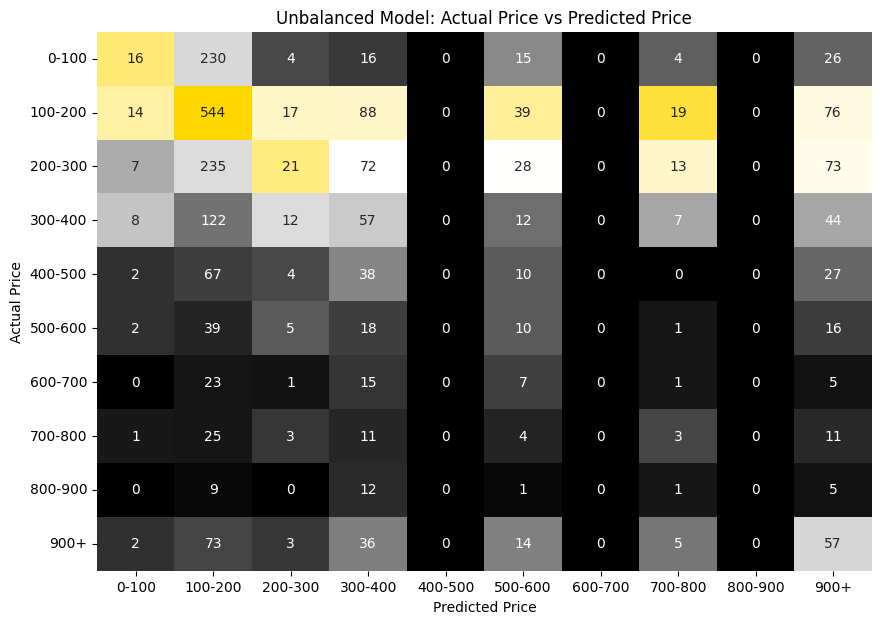

In [49]:
cm_df = pd.DataFrame(unbalanced_cm, index=unbalanced_price_list, columns=unbalanced_price_list)

column_sums = cm_df.sum(axis=0)
cm_df_normalized = cm_df.div(column_sums.where(column_sums != 0, 1), axis=1)

colors = ["black", "white", "gold"] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Price')
plt.xlabel('Predicted Price')
plt.title('Unbalanced Model: Actual Price vs Predicted Price')
plt.show()

In [50]:
unbalanced_accuracy = accuracy_score(true_labels, predicted_labels)
unbalanced_precision = precision_score(true_labels, predicted_labels, average='macro')
unbalanced_recall = recall_score(true_labels, predicted_labels, average='macro')
unbalanced_f1 = f1_score(true_labels, predicted_labels, average='macro')
unbalanced_report = classification_report(true_labels, predicted_labels, target_names=unbalanced_price_list)

unbalanced_metrics = pd.DataFrame([{
    'Model': 'Unbalanced Price Model',
    'Accuracy': unbalanced_accuracy,
    'Precision': unbalanced_precision,
    'Recall': unbalanced_recall,
    'F1 Score': unbalanced_f1
}])
metrics_df = pd.concat([metrics_df, unbalanced_metrics], ignore_index=True)


print(f"Unbalanced Accuracy: {unbalanced_accuracy}")
print(f"Unbalanced Precision: {unbalanced_precision}")
print(f"Unbalanced Recall: {unbalanced_recall}")
print(f"Unbalanced F1 Score: {unbalanced_f1}")
print(unbalanced_report)

Unbalanced Accuracy: 0.2967309304274937
Unbalanced Precision: 0.1457300005981298
Unbalanced Recall: 0.14599486448978188
Unbalanced F1 Score: 0.12094976234911725
              precision    recall  f1-score   support

       0-100       0.31      0.05      0.09       311
     100-200       0.40      0.68      0.50       797
     200-300       0.30      0.05      0.08       449
     300-400       0.16      0.22      0.18       262
     400-500       0.00      0.00      0.00       148
     500-600       0.07      0.11      0.09        91
     600-700       0.00      0.00      0.00        52
     700-800       0.06      0.05      0.05        58
     800-900       0.00      0.00      0.00        28
        900+       0.17      0.30      0.22       190

   micro avg       0.30      0.30      0.30      2386
   macro avg       0.15      0.15      0.12      2386
weighted avg       0.26      0.30      0.24      2386
 samples avg       0.30      0.30      0.30      2386



/Users/kelley/anaconda3/envs/snakeEnv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kelley/anaconda3/envs/snakeEnv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/9q/kg9gzt1s4d36gdnlr8nf75m40000gn/T/ipykernel_13427/4210602627.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the rele

### Modified

In [51]:
true_labels = []
predicted_labels = []

binary_predictions_list = unbalanced_binary_mod_predictions.tolist()
prediction_count = 0

for batch in unbalanced_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(2386, 10)
(2386, 10)


In [52]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
unbalanced_modified_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(unbalanced_modified_cm)

[[ 46 228   2   5   1   4   0   0   0  25]
 [ 36 567   9  47   6  14   0   4   0 114]
 [  4 264  14  48   2   7   0   5   0 105]
 [  7 142   9  41   3   9   0   1   0  50]
 [  0  71   7  17   1  10   0   1   0  41]
 [  1  39   2  13   2   9   0   0   0  25]
 [  3  26   1  10   0   4   0   0   0   8]
 [  4  24   1   8   0   2   0   3   0  16]
 [  0  15   0   5   1   0   0   0   0   7]
 [  4  74   4  23   0  10   0   1   0  74]]


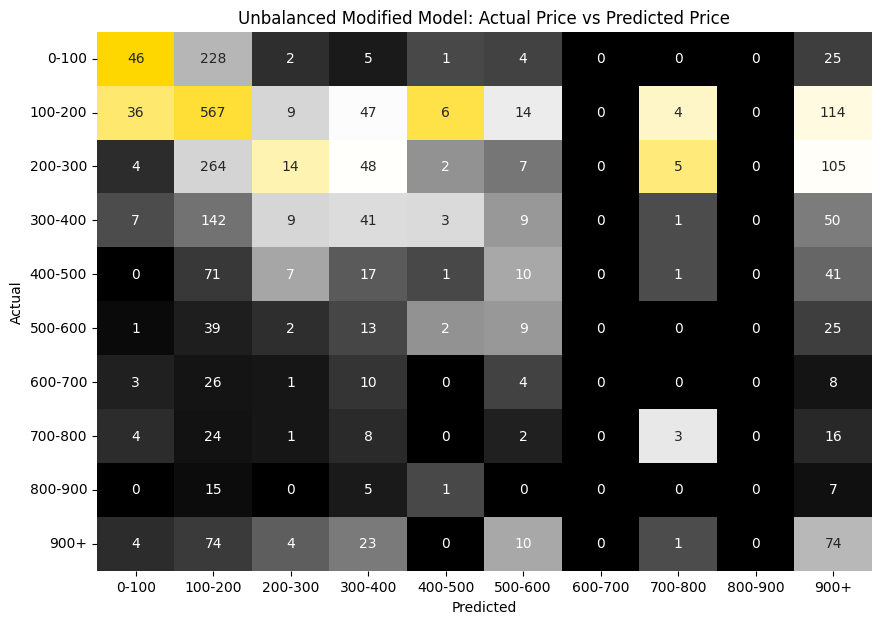

In [53]:
cm_df = pd.DataFrame(unbalanced_modified_cm, index=unbalanced_price_list, columns=unbalanced_price_list)
column_sums = cm_df.sum(axis=0)
cm_df_normalized = cm_df.div(column_sums.where(column_sums != 0, 1), axis=1)

colors = ["black", "white", "gold"] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Unbalanced Modified Model: Actual Price vs Predicted Price')
plt.show()

In [54]:
unbalanced_modified_accuracy = accuracy_score(true_labels, predicted_labels)
unbalanced_modified_precision = precision_score(true_labels, predicted_labels, average='macro')
unbalanced_modified_recall = recall_score(true_labels, predicted_labels, average='macro')
unbalanced_modified_f1 = f1_score(true_labels, predicted_labels, average='macro')
unbalanced_modified_report = classification_report(true_labels, predicted_labels, target_names=unbalanced_price_list)

unbalanced_modified_metrics = pd.DataFrame([{
    'Model': 'Unbalanced Modified Price Model',
    'Accuracy': unbalanced_modified_accuracy,
    'Precision': unbalanced_modified_precision,
    'Recall': unbalanced_modified_recall,
    'F1 Score': unbalanced_modified_f1
}])
metrics_df = pd.concat([metrics_df, unbalanced_modified_metrics], ignore_index=True)



print(f"Unbalanced Modified Accuracy: {unbalanced_modified_accuracy}")
print(f"Unbalanced Modified Precision: {unbalanced_modified_precision}")
print(f"Unbalanced Modified Recall: {unbalanced_modified_recall}")
print(f"Unbalanced Modified F1 Score: {unbalanced_modified_f1}")
print(unbalanced_modified_report)

Unbalanced Modified Accuracy: 0.31642917015926236
Unbalanced Modified Precision: 0.1855858666288975
Unbalanced Modified Recall: 0.15938524129673137
Unbalanced Modified F1 Score: 0.13860827233180945
              precision    recall  f1-score   support

       0-100       0.44      0.15      0.22       311
     100-200       0.39      0.71      0.50       797
     200-300       0.29      0.03      0.06       449
     300-400       0.19      0.16      0.17       262
     400-500       0.06      0.01      0.01       148
     500-600       0.13      0.10      0.11        91
     600-700       0.00      0.00      0.00        52
     700-800       0.20      0.05      0.08        58
     800-900       0.00      0.00      0.00        28
        900+       0.16      0.39      0.23       190

   micro avg       0.32      0.32      0.32      2386
   macro avg       0.19      0.16      0.14      2386
weighted avg       0.29      0.32      0.25      2386
 samples avg       0.32      0.32      0.32 

/Users/kelley/anaconda3/envs/snakeEnv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kelley/anaconda3/envs/snakeEnv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Balanced Price Model Evaluation

In [55]:
balanced_price_list = ['17-93', '93-116', '116-143', '143-177', '177-217', '217-272',
'272-340', '340-457', '457-766', '766+']

### Original 

In [87]:
true_labels = []
predicted_labels = []

binary_predictions_list = balanced_binary_predictions.tolist()
prediction_count = 0

for batch in balanced_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(2386, 10)
(2386, 10)


In [88]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
balanced_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(balanced_cm)

[[  2  44  65   0   0   0  13   0 119   3]
 [  0  39  73   1   0   0  23   0 114   2]
 [  0  18  71   0   0   0  20   0 119   1]
 [  0  22  58   0   0   0  19   0 140   8]
 [  1  10  57   0   0   0  12   0 162   4]
 [  0   9  49   1   0   1  26   0 162   4]
 [  0  11  34   1   0   1  14   0 142   9]
 [  0   7  37   0   0   2  20   0 175   4]
 [  0  10  31   0   0   0  18   0 149   8]
 [  0   9  25   0   0   0  19   0 173  15]]


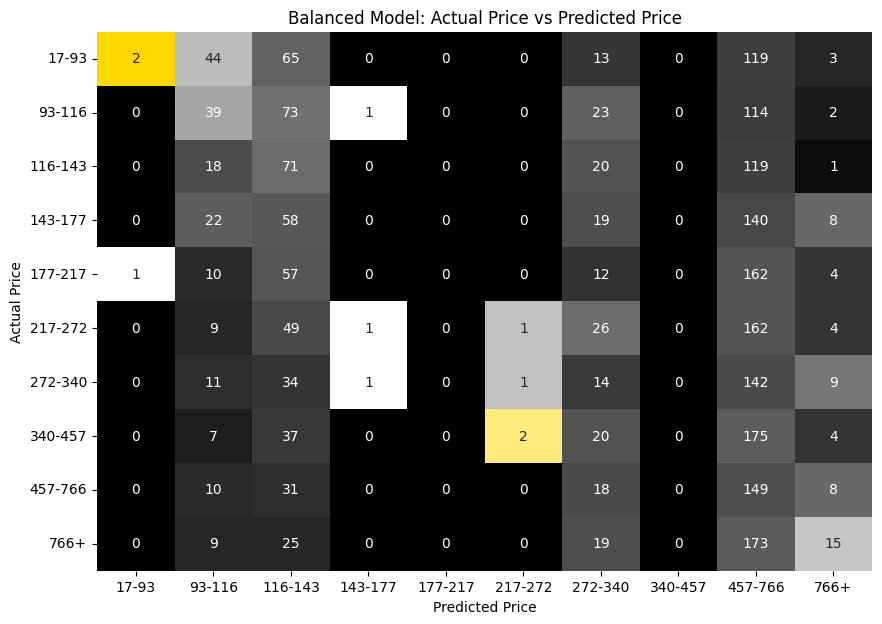

In [89]:
cm_df = pd.DataFrame(balanced_cm, index=balanced_price_list, columns=balanced_price_list)

column_sums = cm_df.sum(axis=0)
cm_df_normalized = cm_df.div(column_sums.where(column_sums != 0, 1), axis=1)

colors = ["black", "white", "gold"] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Price')
plt.xlabel('Predicted Price')
plt.title('Balanced Model: Actual Price vs Predicted Price')
plt.show()

In [91]:
balanced_accuracy = accuracy_score(true_labels, predicted_labels)
balanced_precision = precision_score(true_labels, predicted_labels, average='macro')
balanced_recall = recall_score(true_labels, predicted_labels, average='macro')
balanced_f1 = f1_score(true_labels, predicted_labels, average='macro')
balanced_report = classification_report(true_labels, predicted_labels, target_names=balanced_price_list)

balanced_metrics = pd.DataFrame([{
    'Model': 'Balanced Price Model',
    'Accuracy': balanced_accuracy,
    'Precision': balanced_precision,
    'Recall': balanced_recall,
    'F1 Score': balanced_f1
}])
metrics_df = pd.concat([metrics_df, balanced_metrics], ignore_index=True)

print(f"Balanced Accuracy: {balanced_accuracy}")
print(f"Balanced Precision: {balanced_precision}")
print(f"Balanced Recall: {balanced_recall}")
print(f"Balanced F1 Score: {balanced_f1}")
print(balanced_report)

Balanced Accuracy: 0.12196144174350378
Balanced Precision: 0.17136569060974322
Balanced Recall: 0.1294997122717529
Balanced F1 Score: 0.07490164593800809
              precision    recall  f1-score   support

       17-93       0.67      0.01      0.02       246
      93-116       0.22      0.15      0.18       252
     116-143       0.14      0.31      0.19       229
     143-177       0.00      0.00      0.00       247
     177-217       0.00      0.00      0.00       246
     217-272       0.25      0.00      0.01       252
     272-340       0.08      0.07      0.07       212
     340-457       0.00      0.00      0.00       245
     457-766       0.10      0.69      0.18       216
        766+       0.26      0.06      0.10       241

   micro avg       0.12      0.12      0.12      2386
   macro avg       0.17      0.13      0.07      2386
weighted avg       0.17      0.12      0.07      2386
 samples avg       0.12      0.12      0.12      2386



/Users/kelley/anaconda3/envs/snakeEnv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kelley/anaconda3/envs/snakeEnv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Modified 

In [92]:
true_labels = []
predicted_labels = []

binary_predictions_list = balanced_binary_mod_predictions.tolist()
prediction_count = 0

for batch in balanced_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(2386, 10)
(2386, 10)


In [93]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
balanced_modified_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(balanced_modified_cm)

[[46 95 54  3 12 18  2  0 14  2]
 [34 76 71  4 14 19  4  1 26  3]
 [10 69 94  8  6 14  5  0 17  6]
 [29 67 69 12  3 25  7  3 27  5]
 [19 33 75  7 11 39 19  2 33  8]
 [11 37 70  9 12 44 17  1 40 11]
 [ 9 34 46  5 11 45 17  2 34  9]
 [17 36 51  3  4 47 28  8 42  9]
 [15 39 35  8 10 29 10  4 53 13]
 [12 33 38  4 14 24 21  4 54 37]]


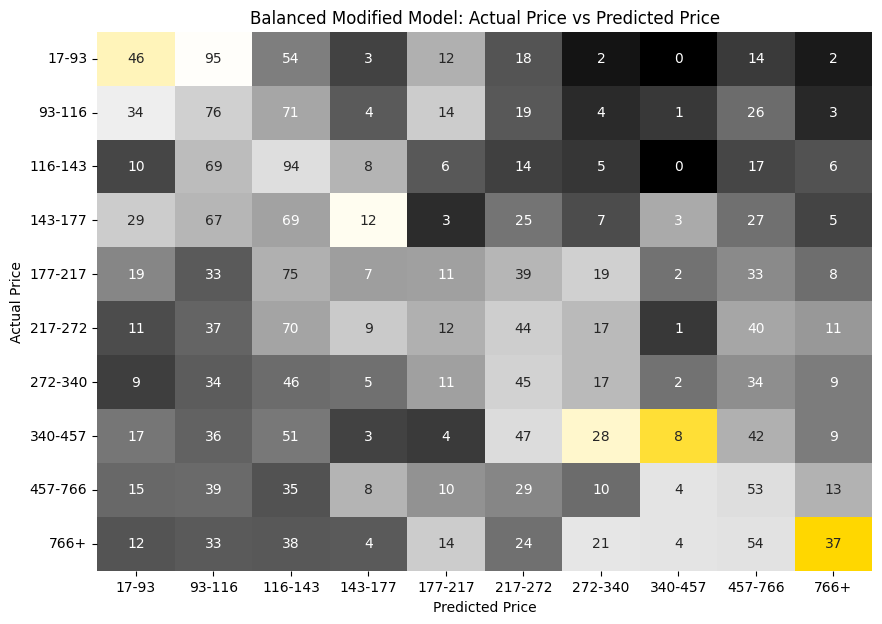

In [94]:
cm_df = pd.DataFrame(balanced_modified_cm, index=balanced_price_list, columns=balanced_price_list)

cm_df_normalized = cm_df.div(cm_df.sum(axis=0), axis=1)

colors = ["black", "white", "gold"] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Price')
plt.xlabel('Predicted Price')
plt.title('Balanced Modified Model: Actual Price vs Predicted Price')
plt.show()

In [95]:
balanced_modified_accuracy = accuracy_score(true_labels, predicted_labels)
balanced_modified_precision = precision_score(true_labels, predicted_labels, average='macro')
balanced_modified_recall = recall_score(true_labels, predicted_labels, average='macro')
balanced_modified_f1 = f1_score(true_labels, predicted_labels, average='macro')
balanced_modified_report = classification_report(true_labels, predicted_labels, target_names=balanced_price_list)

balanced_modified_metrics = pd.DataFrame([{
    'Model': 'Balanced Modified Price Model',
    'Accuracy': balanced_modified_accuracy,
    'Precision': balanced_modified_precision,
    'Recall': balanced_modified_recall,
    'F1 Score': balanced_modified_f1
}])
metrics_df = pd.concat([metrics_df, balanced_modified_metrics], ignore_index=True)


print(f"Balanced Accuracy: {balanced_modified_accuracy}")
print(f"Balanced Precision: {balanced_modified_precision}")
print(f"Balanced Recall: {balanced_modified_recall}")
print(f"Balanced F1 Score: {balanced_modified_f1}")
print(balanced_modified_report)

Balanced Accuracy: 0.16680637049455155
Balanced Precision: 0.1944535434703563
Balanced Recall: 0.16787002203545423
Balanced F1 Score: 0.14927361470704123
              precision    recall  f1-score   support

       17-93       0.23      0.19      0.21       246
      93-116       0.15      0.30      0.20       252
     116-143       0.16      0.41      0.23       229
     143-177       0.19      0.05      0.08       247
     177-217       0.11      0.04      0.06       246
     217-272       0.14      0.17      0.16       252
     272-340       0.13      0.08      0.10       212
     340-457       0.32      0.03      0.06       245
     457-766       0.16      0.25      0.19       216
        766+       0.36      0.15      0.22       241

   micro avg       0.17      0.17      0.17      2386
   macro avg       0.19      0.17      0.15      2386
weighted avg       0.20      0.17      0.15      2386
 samples avg       0.17      0.17      0.17      2386



## Brand Model Evaluation

In [96]:
brand_list = ['ADIDAS', 'AIR JORDAN', 'BAPESTA', 'NEW BALANCE', 'NIKE', 'YEEZY']

### Original 

In [97]:
true_labels = []
predicted_labels = []

binary_predictions_list = brand_binary_predictions.tolist()
prediction_count = 0

for batch in brand_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(2386, 6)
(2386, 6)


In [98]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
brand_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(brand_cm)

[[ 227    0    3    0   10    0]
 [   3  462    5    0   20    0]
 [   1    2   95    0    2    0]
 [   0    3    2  113    1    0]
 [   1   24   18    0 1351    0]
 [   0    0    1    0    0   42]]


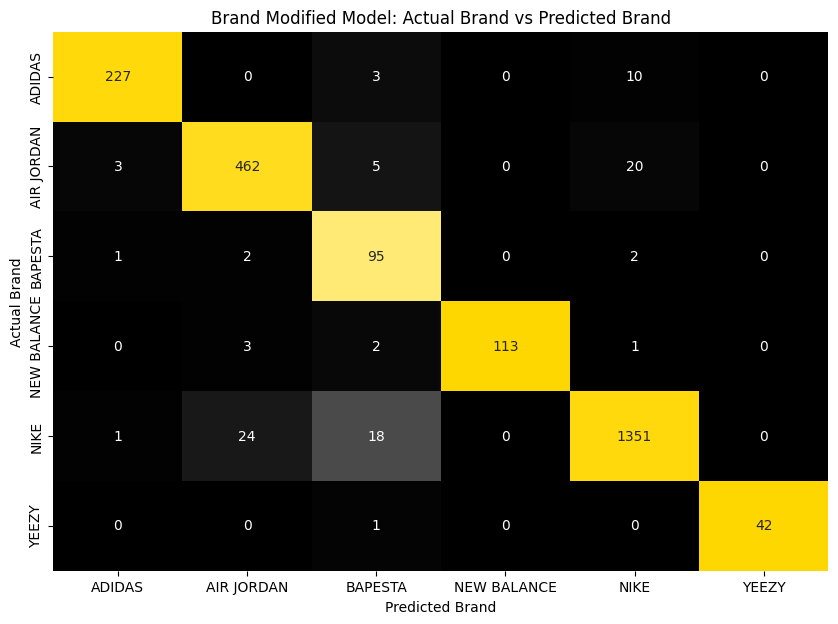

In [99]:
cm_df = pd.DataFrame(brand_cm, index=brand_list, columns=brand_list)

cm_df_normalized = cm_df.div(cm_df.sum(axis=0), axis=1)

colors = ["black", "white", "gold"] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Brand')
plt.xlabel('Predicted Brand')
plt.title('Brand Modified Model: Actual Brand vs Predicted Brand')
plt.show()

In [70]:
brand_accuracy = accuracy_score(true_labels, predicted_labels)
brand_precision = precision_score(true_labels, predicted_labels, average='macro')
brand_recall = recall_score(true_labels, predicted_labels, average='macro')
brand_f1 = f1_score(true_labels, predicted_labels, average='macro')
brand_report = classification_report(true_labels, predicted_labels, target_names=brand_list)

brand_metrics = pd.DataFrame([{
    'Model': 'Brand Model',
    'Accuracy': brand_accuracy,
    'Precision': brand_precision,
    'Recall': brand_recall,
    'F1 Score': brand_f1
}])
metrics_df = pd.concat([metrics_df, brand_metrics], ignore_index=True)


print(f"Brand Accuracy: {brand_accuracy}")
print(f"Brand Precision: {brand_precision}")
print(f"Brand Recall: {brand_recall}")
print(f"Brand F1 Score: {brand_f1}")
print(brand_report)

Brand Accuracy: 0.9597652975691534
Brand Precision: 0.943611706838014
Brand Recall: 0.9556946682057205
Brand F1 Score: 0.9478316884559698
              precision    recall  f1-score   support

      ADIDAS       0.98      0.95      0.96       240
  AIR JORDAN       0.94      0.94      0.94       490
     BAPESTA       0.77      0.95      0.85       100
 NEW BALANCE       1.00      0.95      0.97       119
        NIKE       0.98      0.97      0.97      1394
       YEEZY       1.00      0.98      0.99        43

   micro avg       0.96      0.96      0.96      2386
   macro avg       0.94      0.96      0.95      2386
weighted avg       0.96      0.96      0.96      2386
 samples avg       0.96      0.96      0.96      2386



### Modified

In [71]:
true_labels = []
predicted_labels = []

binary_predictions_list = brand_binary_mod_predictions.tolist()
prediction_count = 0

for batch in brand_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(2386, 6)
(2386, 6)


In [72]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
brand_modified_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(brand_modified_cm)

[[ 228    5    2    0    5    0]
 [   2  453    4    0   30    1]
 [   0    4   91    1    4    0]
 [   0    2    0  116    1    0]
 [   4   26   13    1 1350    0]
 [   1    1    0    2    0   39]]


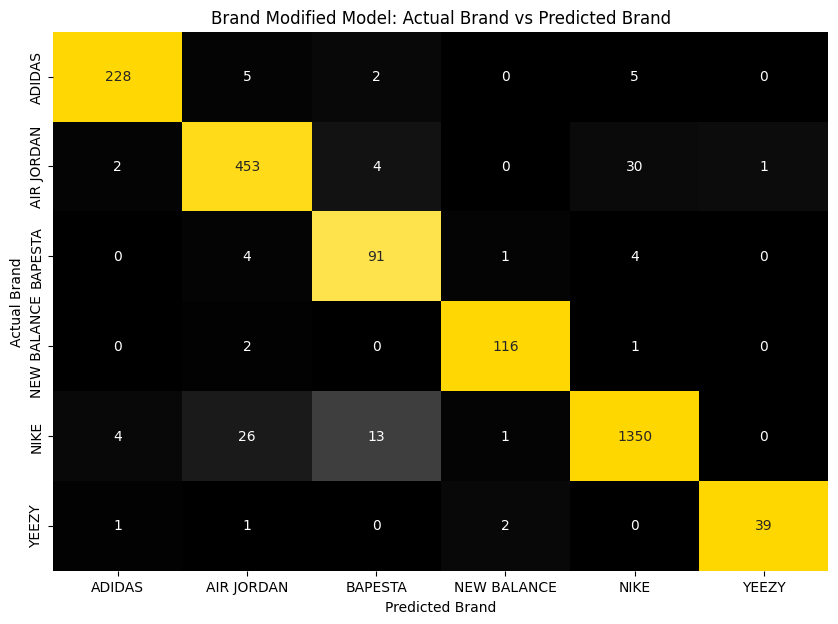

In [73]:
cm_df = pd.DataFrame(brand_modified_cm, index=brand_list, columns=brand_list)

cm_df_normalized = cm_df.div(cm_df.sum(axis=0), axis=1)

colors = ["black", "white", "gold", ] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Brand')
plt.xlabel('Predicted Brand')
plt.title('Brand Modified Model: Actual Brand vs Predicted Brand')
plt.show()

In [74]:
brand_modified_accuracy = accuracy_score(true_labels, predicted_labels)
brand_modified_precision = precision_score(true_labels, predicted_labels, average='macro')
brand_modified_recall = recall_score(true_labels, predicted_labels, average='macro')
brand_modified_f1 = f1_score(true_labels, predicted_labels, average='macro')
brand_modified_report = classification_report(true_labels, predicted_labels, target_names=brand_list)

brand_modified_metrics = pd.DataFrame([{
    'Model': 'Brand Modified Model',
    'Accuracy': brand_modified_accuracy,
    'Precision': brand_modified_precision,
    'Recall': brand_modified_recall,
    'F1 Score': brand_modified_f1
}])
metrics_df = pd.concat([metrics_df, brand_modified_metrics], ignore_index=True)


print(f"Brand Modified Accuracy: {brand_modified_accuracy}")
print(f"Brand Modified Precision: {brand_modified_precision}")
print(f"Brand Modified Recall: {brand_modified_recall}")
print(f"Brand Modified F1 Score: {brand_modified_f1}")
print(brand_modified_report)

Brand Modified Accuracy: 0.9543168482816429
Brand Modified Precision: 0.9388303510205264
Brand Modified Recall: 0.9391154351700975
Brand Modified F1 Score: 0.9384186644501487
              precision    recall  f1-score   support

      ADIDAS       0.97      0.95      0.96       240
  AIR JORDAN       0.92      0.92      0.92       490
     BAPESTA       0.83      0.91      0.87       100
 NEW BALANCE       0.97      0.97      0.97       119
        NIKE       0.97      0.97      0.97      1394
       YEEZY       0.97      0.91      0.94        43

   micro avg       0.95      0.95      0.95      2386
   macro avg       0.94      0.94      0.94      2386
weighted avg       0.95      0.95      0.95      2386
 samples avg       0.95      0.95      0.95      2386



## Model Model Evaluation

In [75]:
model_list = ['NB 2002R', 'AIR MAX 1', 'NIKE AIR MAX 90', 'AJ 1','AJ 11', 'AJ 12', 'AJ 2', 
'AJ 3', 'AJ 4', 'AJ 5', 'AJ 6', 'BAPESTA', 'NIKE DUNK LOW','NIKE DUNK HIGH', 'NB550',
'NB990', 'ADIDAS STAN SMITH', 'YZY 700', 'YZY 350', 'YZY RNR', 'NIKE AF1', 
'ADIDAS FORUM', 'ADIDAS SAMBA', 'YZY SLIDES'
]

### Original 

In [101]:
true_labels = []
predicted_labels = []

binary_predictions_list = model_binary_predictions.tolist()
prediction_count = 0

for batch in model_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(2386, 24)
(2386, 24)


In [102]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
model_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(model_cm)


[[ 38   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 172   1   0   0   1   0   1   0   0   2   0   1   0   0   0   0   0
    0   0   4   0   0   0]
 [  0   3 216   1   0   0   0   0   0   0   2   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   4   0 240   2   0  10   0   0   0   3   2   2   3   0   0   1   0
    0   0   7   0   0   0]
 [  0   1   0   0  24   0   0   0   0   0   1   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   1  21   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   1   1   0  24   0   0   3   0   1   0   0   0   0   0   0
    0   0   2   0   0   0]
 [  0   3   0   1   0   1   0  29   0   0   5   0   1   0   0   0   0   0
    0   0   1   0   0   0]
 [  0   0   1   0   0   0   0   0  25   0   1   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0  38   1   0   1   0   0   0   0   0
    0   0   0   0

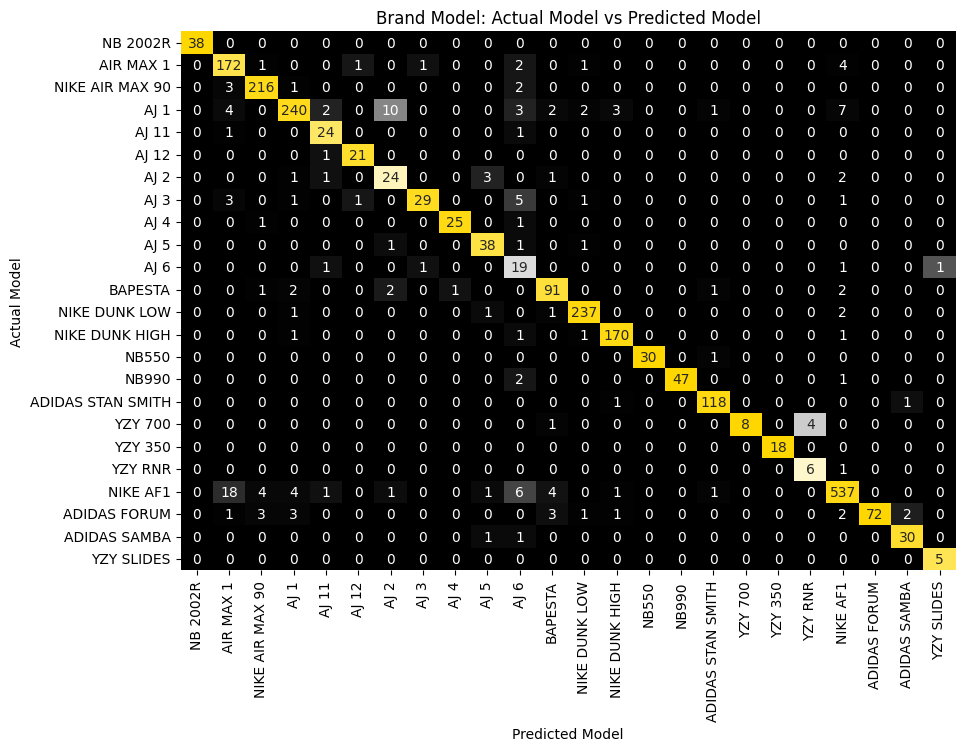

In [103]:
cm_df = pd.DataFrame(model_cm, index=model_list, columns=model_list)

cm_df_normalized = cm_df.div(cm_df.sum(axis=0), axis=1)

colors = ["black", "white", "gold", ] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Model')
plt.xlabel('Predicted Model')
plt.title('Brand Model: Actual Model vs Predicted Model')
plt.show()

In [104]:
model_accuracy = accuracy_score(true_labels, predicted_labels)
model_precision = precision_score(true_labels, predicted_labels, average='macro')
model_recall = recall_score(true_labels, predicted_labels, average='macro')
model_f1 = f1_score(true_labels, predicted_labels, average='macro')
model_report = classification_report(true_labels, predicted_labels, target_names=model_list)

model_metrics = pd.DataFrame([{
    'Model': 'Model Model',
    'Accuracy': model_accuracy,
    'Precision': model_precision,
    'Recall': model_recall,
    'F1 Score': model_f1
}])
metrics_df = pd.concat([metrics_df, model_metrics], ignore_index=True)


print(f"Model Accuracy: {model_accuracy}")
print(f"Model Precision: {model_precision}")
print(f"Model Recall: {model_recall}")
print(f"Model F1 Score: {model_f1}")
print(model_report)

Model Accuracy: 0.9283319362950545
Model Precision: 0.890699619780137
Model Recall: 0.9051009403758213
Model F1 Score: 0.8904039856802104
                   precision    recall  f1-score   support

         NB 2002R       1.00      1.00      1.00        38
        AIR MAX 1       0.85      0.95      0.90       182
  NIKE AIR MAX 90       0.96      0.97      0.96       222
             AJ 1       0.94      0.88      0.91       274
            AJ 11       0.80      0.92      0.86        26
            AJ 12       0.91      0.95      0.93        22
             AJ 2       0.63      0.75      0.69        32
             AJ 3       0.94      0.71      0.81        41
             AJ 4       0.96      0.93      0.94        27
             AJ 5       0.86      0.93      0.89        41
             AJ 6       0.43      0.83      0.57        23
          BAPESTA       0.88      0.91      0.90       100
    NIKE DUNK LOW       0.97      0.98      0.98       242
   NIKE DUNK HIGH       0.97      0

### Modified 

In [105]:
true_labels = []
predicted_labels = []

binary_predictions_list = model_binary_mod_predictions.tolist()
prediction_count = 0

for batch in model_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(2386, 24)
(2386, 24)


In [106]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
model_modified_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(model_modified_cm)

[[ 38   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 163   2   0   1   0   0   0   0   0   0   2   0   0   0   0   0   0
    0   0  14   0   0   0]
 [  0   3 218   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   1   0   0   0]
 [  0   5   0 239   0   0  12   0   0   0   1   5   2   2   0   0   1   0
    0   0   6   1   0   0]
 [  1   0   0   0  24   0   0   0   0   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   1   1   1   0  17   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   2   0   0   0]
 [  0   2   0   1   0   0  21   0   0   3   1   0   0   0   1   0   0   0
    0   0   2   1   0   0]
 [  0   3   4   2  10   0   0  12   0   0   3   2   0   0   0   0   0   0
    0   0   5   0   0   0]
 [  0   1   2   0   1   0   0   0  18   0   2   0   0   1   0   0   0   0
    0   0   2   0   0   0]
 [  0   0   0   0   4   0   0   0   0  33   2   2   0   0   0   0   0   0
    0   0   0   0

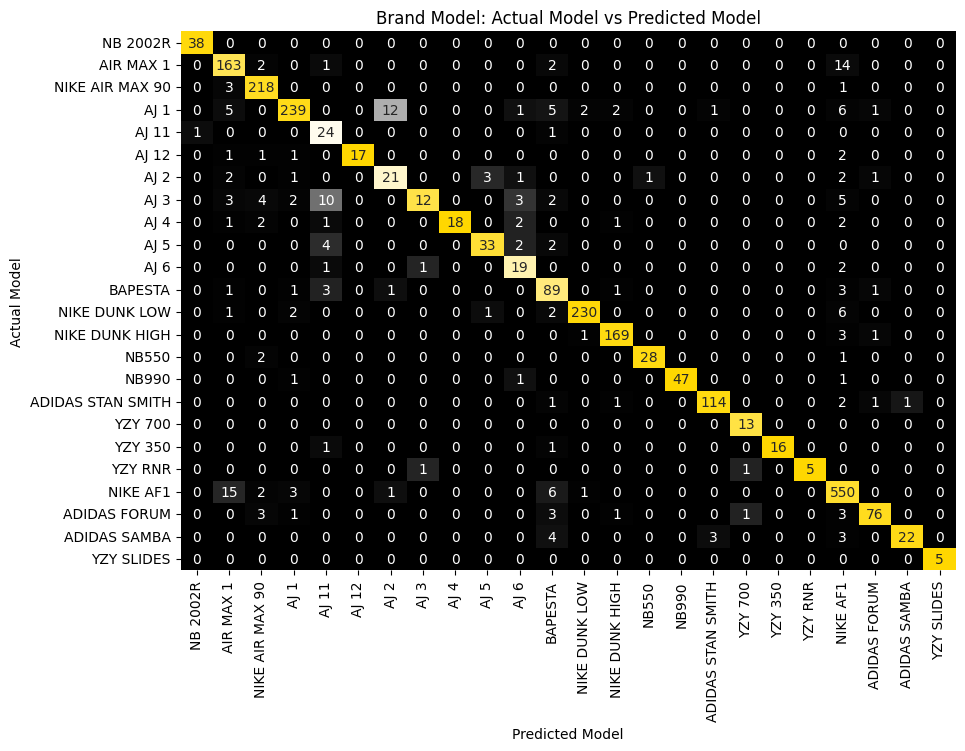

In [107]:
cm_df = pd.DataFrame(model_modified_cm, index=model_list, columns=model_list)

cm_df_normalized = cm_df.div(cm_df.sum(axis=0), axis=1)

colors = ["black", "white", "gold", ] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Model')
plt.xlabel('Predicted Model')
plt.title('Brand Model: Actual Model vs Predicted Model')
plt.show()

In [109]:
model_modified_accuracy = accuracy_score(true_labels, predicted_labels)
model_modified_precision = precision_score(true_labels, predicted_labels, average='macro')
model_modified_recall = recall_score(true_labels, predicted_labels, average='macro')
model_modified_f1 = f1_score(true_labels, predicted_labels, average='macro')
model_modified_report = classification_report(true_labels, predicted_labels, target_names=model_list)

model_modified_metrics = pd.DataFrame([{
    'Model': 'Modified Model Model',
    'Accuracy': model_modified_accuracy,
    'Precision': model_modified_precision,
    'Recall': model_modified_recall,
    'F1 Score': model_modified_f1
}])
metrics_df = pd.concat([metrics_df, model_modified_metrics], ignore_index=True)

print(f"Model Modified Accuracy: {model_modified_accuracy}")
print(f"Model Modified Precision: {model_modified_precision}")
print(f"Model Modified Recall: {model_modified_recall}")
print(f"Model Modified F1 Score: {model_modified_f1}")
print(model_modified_report)

Model Modified Accuracy: 0.9077954735959766
Model Modified Precision: 0.8972974723317915
Model Modified Recall: 0.8501245584815056
Model Modified F1 Score: 0.8604028567544492
                   precision    recall  f1-score   support

         NB 2002R       0.97      1.00      0.99        38
        AIR MAX 1       0.84      0.90      0.86       182
  NIKE AIR MAX 90       0.93      0.98      0.96       222
             AJ 1       0.95      0.87      0.91       274
            AJ 11       0.53      0.92      0.68        26
            AJ 12       1.00      0.77      0.87        22
             AJ 2       0.60      0.66      0.63        32
             AJ 3       0.86      0.29      0.44        41
             AJ 4       1.00      0.67      0.80        27
             AJ 5       0.89      0.80      0.85        41
             AJ 6       0.66      0.83      0.73        23
          BAPESTA       0.75      0.89      0.82       100
    NIKE DUNK LOW       0.98      0.95      0.97       24

# ALL MODELS

In [84]:
metrics_df.head(10)

,Model,Accuracy,Precision,Recall,F1 Score
0,Unbalanced Price Model,0.296731,0.145730,0.145995,0.120950
1,Unbalanced Modified Price Model,0.316429,0.185586,0.159385,0.138608
2,Balanced Price Model,0.121961,0.171366,0.129500,0.074902
3,Balanced Modified Price Model,0.166806,0.194454,0.167870,0.149274
4,Brand Model,0.959765,0.943612,0.955695,0.947832
5,Brand Model,0.959765,0.943612,0.955695,0.947832
6,Brand Modified Model,0.954317,0.938830,0.939115,0.938419
7,Model Model,0.928332,0.890700,0.905101,0.890404
8,Modified Model Model,0.907795,0.897297,0.850125,0.860403


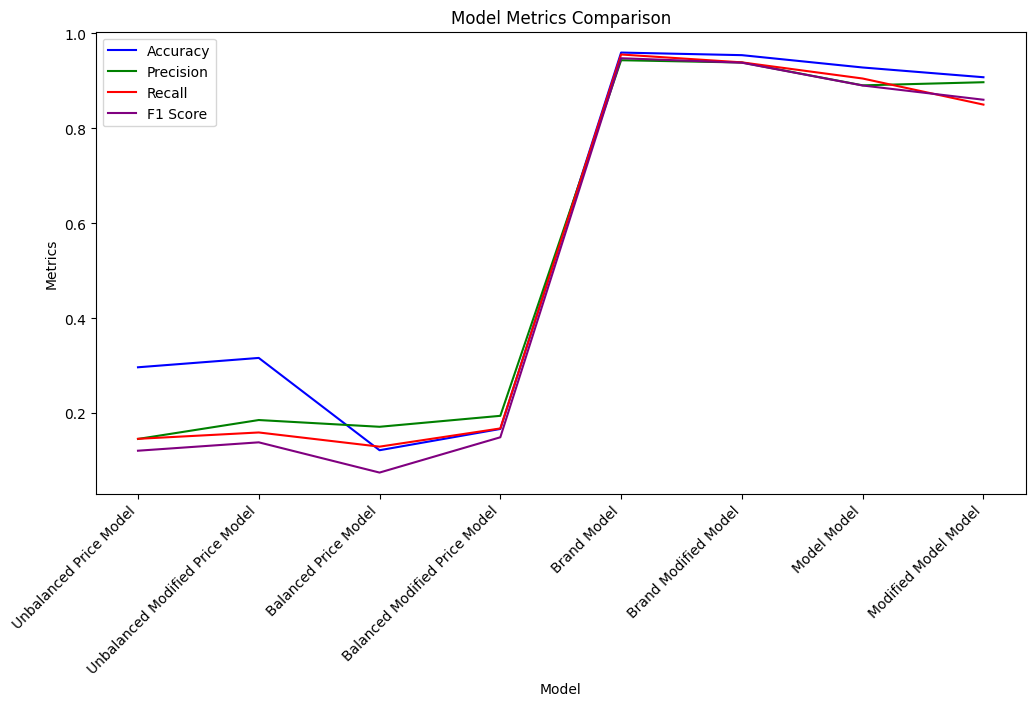

In [85]:
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['Model'], metrics_df['Accuracy'], color='blue', label='Accuracy')
plt.plot(metrics_df['Model'], metrics_df['Precision'], color='green', label='Precision')
plt.plot(metrics_df['Model'], metrics_df['Recall'], color='red', label='Recall')
plt.plot(metrics_df['Model'], metrics_df['F1 Score'], color='purple', label='F1 Score')
plt.xlabel('Model')
plt.ylabel('Metrics')
plt.title('Model Metrics Comparison')
plt.xticks(rotation=45, ha="right") 
plt.legend()  
plt.show()